# On Deep Learning-Based Channel Decoding

If you want to cite this notebook, please use the following bibtext entry:

    @article{nn-decoding,
      title={On Deep Learning-Based Channel Decoding},
      author={Tobias Gruber and
              Sebastian Cammerer and
              Jakob Hoydis and
              Stephan ten Brink}
      journal={CoRR}
      year={2017}
      url= {http://arxiv.org/abs/1701.07738}
    }

Running this example requires Keras installed with the Theano backend. For GPU support nvidia-docker is required. A Dockerfile is provided to employ this setup quickly.

Our simulation setup was inspired by material from http://radioml.org.


In [1]:
import numpy as np
# import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# Parameters

In [2]:
k = 8                       # number of information bits
N = 16                      # code length
train_SNR_Eb = 1            # training-Eb/No

nb_epoch = 2**12            # number of learning epochs
code = 'polar'              # type of code ('random' or 'polar')
design = [128, 64, 32]      # each list entry defines the number of nodes in a layer
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
optimizer = 'adam'           
loss = 'mse'                # or 'binary_crossentropy'

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

# Define NN model

In [3]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
#     return K.sum(K.not_equal(y_true, K.round(y_pred)))
#     return tf.reduce_mean(K.cast(K.equal(y_true, K.round(y_pred)),dtype = 'float32'))
    return K.sum(K.cast(K.not_equal(y_true, K.round(y_pred)),dtype = 'int32'))

In [4]:
# Define modulator
modulator_layers = [Lambda(modulateBPSK, 
                          input_shape=(N,), output_shape=return_output_shape, name="modulator")]
modulator = compose_model(modulator_layers)
modulator.compile(optimizer=optimizer, loss=loss)

# Define noise
noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                       input_shape=(N,), output_shape=return_output_shape, name="noise")]
noise = compose_model(noise_layers)
noise.compile(optimizer=optimizer, loss=loss)

# Define LLR
llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                     input_shape=(N,), output_shape=return_output_shape, name="LLR")]
llr = compose_model(llr_layers)
llr.compile(optimizer=optimizer, loss=loss)

# Define decoder 
decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
for i in range(1,len(design)):
    decoder_layers.append(Dense(design[i], activation='relu'))
decoder_layers.append(Dense(k, activation='sigmoid'))
decoder = compose_model(decoder_layers)
decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])

# Define model
if LLR:
    model_layers = modulator_layers + noise_layers + llr_layers + decoder_layers
else:
    model_layers = modulator_layers + noise_layers + decoder_layers
model = compose_model(model_layers)
model.compile(optimizer=optimizer, loss=loss, metrics=[ber])

# Data Generation

In [5]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [6]:
# Create all possible information words
d = np.zeros((2**k,k),dtype=bool)
for i in range(1,2**k):
    d[i]= inc_bool(d[i-1])

# Create sets of all possible codewords (codebook)
if code == 'polar':   
    
    A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
    x = np.zeros((2**k, N),dtype=bool)
    u = np.zeros((2**k, N),dtype=bool)
    u[:,A] = d

    for i in range(0,2**k):
        x[i] = polar_transform_iter(u[i])

elif code == 'random':
    
    np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
    x = np.random.randint(0,2,size=(2**k,N), dtype=bool)

# Train Neural Network

In [7]:
model.summary()
history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=1, shuffle=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 modulator (Lambda)          (None, 16)                0         
                                                                 
 noise (Lambda)              (None, 16)                0         
                                                                 
 dense (Dense)               (None, 128)               2176      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
Total params: 12,776
Trainable params: 12,776
Non-trai

1/1 [==============================] - 0s 5ms/step - loss: 0.1881 - ber: 0.3018
Epoch 76/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1889 - ber: 0.3115
Epoch 77/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1834 - ber: 0.2720
Epoch 78/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1903 - ber: 0.3066
Epoch 79/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1808 - ber: 0.2866
Epoch 80/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1890 - ber: 0.3062
Epoch 81/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1868 - ber: 0.2905
Epoch 82/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1808 - ber: 0.2827
Epoch 83/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1820 - ber: 0.2974
Epoch 84/4096
1/1 [==============================] - 0s 4ms/step - loss: 0.1841 - ber: 0.2915
Epoch 85/4096
1/1 [==============================] - 0s 5ms/step - loss: 0

1/1 [==============================] - 0s 5ms/step - loss: 0.1522 - ber: 0.2524
Epoch 162/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1538 - ber: 0.2637
Epoch 163/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1555 - ber: 0.2842
Epoch 164/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1510 - ber: 0.2524
Epoch 165/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1567 - ber: 0.2764
Epoch 166/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1521 - ber: 0.2700
Epoch 167/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1534 - ber: 0.2515
Epoch 168/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1549 - ber: 0.2627
Epoch 169/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1628 - ber: 0.2856
Epoch 170/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1554 - ber: 0.2607
Epoch 171/4096
1/1 [==============================] - 0s 5ms/step

1/1 [==============================] - 0s 6ms/step - loss: 0.1511 - ber: 0.2578
Epoch 248/4096
1/1 [==============================] - 0s 4ms/step - loss: 0.1492 - ber: 0.2544
Epoch 249/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1454 - ber: 0.2568
Epoch 250/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1445 - ber: 0.2456
Epoch 251/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1436 - ber: 0.2485
Epoch 252/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1452 - ber: 0.2466
Epoch 253/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1487 - ber: 0.2612
Epoch 254/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1478 - ber: 0.2524
Epoch 255/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1503 - ber: 0.2710
Epoch 256/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1487 - ber: 0.2593
Epoch 257/4096
1/1 [==============================] - 0s 6ms/step

1/1 [==============================] - 0s 5ms/step - loss: 0.1479 - ber: 0.2476
Epoch 334/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1408 - ber: 0.2329
Epoch 335/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1432 - ber: 0.2461
Epoch 336/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1524 - ber: 0.2544
Epoch 337/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1434 - ber: 0.2544
Epoch 338/4096
1/1 [==============================] - 0s 4ms/step - loss: 0.1420 - ber: 0.2339
Epoch 339/4096
1/1 [==============================] - 0s 4ms/step - loss: 0.1390 - ber: 0.2471
Epoch 340/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1389 - ber: 0.2310
Epoch 341/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1459 - ber: 0.2388
Epoch 342/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1452 - ber: 0.2441
Epoch 343/4096
1/1 [==============================] - 0s 6ms/step

1/1 [==============================] - 0s 6ms/step - loss: 0.1358 - ber: 0.2324
Epoch 420/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1404 - ber: 0.2495
Epoch 421/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1435 - ber: 0.2446
Epoch 422/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1440 - ber: 0.2446
Epoch 423/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1437 - ber: 0.2524
Epoch 424/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1423 - ber: 0.2456
Epoch 425/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1408 - ber: 0.2427
Epoch 426/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1419 - ber: 0.2393
Epoch 427/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1419 - ber: 0.2275
Epoch 428/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1363 - ber: 0.2373
Epoch 429/4096
1/1 [==============================] - 0s 5ms/step

1/1 [==============================] - 0s 8ms/step - loss: 0.1397 - ber: 0.2451
Epoch 506/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1350 - ber: 0.2256
Epoch 507/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1435 - ber: 0.2271
Epoch 508/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1396 - ber: 0.2256
Epoch 509/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1385 - ber: 0.2280
Epoch 510/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1368 - ber: 0.2231
Epoch 511/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1414 - ber: 0.2412
Epoch 512/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1411 - ber: 0.2334
Epoch 513/4096
1/1 [==============================] - 0s 4ms/step - loss: 0.1371 - ber: 0.2212
Epoch 514/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1391 - ber: 0.2383
Epoch 515/4096
1/1 [==============================] - 0s 6ms/step

1/1 [==============================] - 0s 5ms/step - loss: 0.1455 - ber: 0.2534
Epoch 592/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1398 - ber: 0.2266
Epoch 593/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1394 - ber: 0.2178
Epoch 594/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1376 - ber: 0.2280
Epoch 595/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1428 - ber: 0.2329
Epoch 596/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1308 - ber: 0.2065
Epoch 597/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1256 - ber: 0.2061
Epoch 598/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1386 - ber: 0.2285
Epoch 599/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.1377 - ber: 0.2305
Epoch 600/4096
1/1 [==============================] - 0s 11ms/step - loss: 0.1443 - ber: 0.2339
Epoch 601/4096
1/1 [==============================] - 0s 6ms/ste

1/1 [==============================] - 0s 5ms/step - loss: 0.1382 - ber: 0.2295
Epoch 678/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1371 - ber: 0.2144
Epoch 679/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1304 - ber: 0.2148
Epoch 680/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1340 - ber: 0.2139
Epoch 681/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1295 - ber: 0.2114
Epoch 682/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1357 - ber: 0.2212
Epoch 683/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1364 - ber: 0.2173
Epoch 684/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1386 - ber: 0.2192
Epoch 685/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1363 - ber: 0.2158
Epoch 686/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1399 - ber: 0.2300
Epoch 687/4096
1/1 [==============================] - 0s 5ms/step

1/1 [==============================] - 0s 5ms/step - loss: 0.1373 - ber: 0.2241
Epoch 764/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1321 - ber: 0.2178
Epoch 765/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1407 - ber: 0.2295
Epoch 766/4096
1/1 [==============================] - 0s 4ms/step - loss: 0.1374 - ber: 0.2231
Epoch 767/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1368 - ber: 0.2202
Epoch 768/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1384 - ber: 0.2222
Epoch 769/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1378 - ber: 0.2183
Epoch 770/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1275 - ber: 0.1938
Epoch 771/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1398 - ber: 0.2305
Epoch 772/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1400 - ber: 0.2222
Epoch 773/4096
1/1 [==============================] - 0s 5ms/step

1/1 [==============================] - 0s 5ms/step - loss: 0.1311 - ber: 0.2056
Epoch 850/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1448 - ber: 0.2266
Epoch 851/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1320 - ber: 0.2061
Epoch 852/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1268 - ber: 0.1943
Epoch 853/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1341 - ber: 0.2021
Epoch 854/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1348 - ber: 0.2173
Epoch 855/4096
1/1 [==============================] - 0s 4ms/step - loss: 0.1369 - ber: 0.2075
Epoch 856/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1314 - ber: 0.2051
Epoch 857/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1391 - ber: 0.2241
Epoch 858/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1316 - ber: 0.2002
Epoch 859/4096
1/1 [==============================] - 0s 6ms/step

1/1 [==============================] - 0s 5ms/step - loss: 0.1346 - ber: 0.2061
Epoch 936/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1312 - ber: 0.2056
Epoch 937/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1294 - ber: 0.1943
Epoch 938/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1237 - ber: 0.1846
Epoch 939/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1232 - ber: 0.1880
Epoch 940/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1360 - ber: 0.2256
Epoch 941/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1241 - ber: 0.1948
Epoch 942/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1424 - ber: 0.2246
Epoch 943/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1292 - ber: 0.2041
Epoch 944/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1266 - ber: 0.2051
Epoch 945/4096
1/1 [==============================] - 0s 7ms/step

1/1 [==============================] - 0s 9ms/step - loss: 0.1321 - ber: 0.1938
Epoch 1022/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1278 - ber: 0.1963
Epoch 1023/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.1250 - ber: 0.1948
Epoch 1024/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1340 - ber: 0.2080
Epoch 1025/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1330 - ber: 0.2148
Epoch 1026/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1241 - ber: 0.1978
Epoch 1027/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1266 - ber: 0.1855
Epoch 1028/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1298 - ber: 0.1978
Epoch 1029/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1333 - ber: 0.2026
Epoch 1030/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1270 - ber: 0.2085
Epoch 1031/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 6ms/step - loss: 0.1225 - ber: 0.1973
Epoch 1107/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1284 - ber: 0.1943
Epoch 1108/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1285 - ber: 0.2007
Epoch 1109/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1242 - ber: 0.1768
Epoch 1110/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1237 - ber: 0.1904
Epoch 1111/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1307 - ber: 0.1953
Epoch 1112/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1354 - ber: 0.2134
Epoch 1113/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1291 - ber: 0.2090
Epoch 1114/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1272 - ber: 0.2065
Epoch 1115/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1160 - ber: 0.1743
Epoch 1116/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.1266 - ber: 0.1934
Epoch 1192/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1289 - ber: 0.2041
Epoch 1193/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1246 - ber: 0.1958
Epoch 1194/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1225 - ber: 0.1733
Epoch 1195/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1280 - ber: 0.1963
Epoch 1196/4096
1/1 [==============================] - 0s 11ms/step - loss: 0.1233 - ber: 0.1826
Epoch 1197/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1256 - ber: 0.1895
Epoch 1198/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1203 - ber: 0.1743
Epoch 1199/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1221 - ber: 0.1821
Epoch 1200/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1182 - ber: 0.1772
Epoch 1201/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 6ms/step - loss: 0.1194 - ber: 0.1821
Epoch 1277/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1262 - ber: 0.1895
Epoch 1278/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1198 - ber: 0.1846
Epoch 1279/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1323 - ber: 0.1943
Epoch 1280/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1213 - ber: 0.1748
Epoch 1281/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1174 - ber: 0.1768
Epoch 1282/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1174 - ber: 0.1729
Epoch 1283/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1238 - ber: 0.1899
Epoch 1284/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1269 - ber: 0.1929
Epoch 1285/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1348 - ber: 0.2095
Epoch 1286/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 4ms/step - loss: 0.1132 - ber: 0.1631
Epoch 1362/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1201 - ber: 0.1777
Epoch 1363/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1291 - ber: 0.1934
Epoch 1364/4096
1/1 [==============================] - 0s 4ms/step - loss: 0.1281 - ber: 0.1943
Epoch 1365/4096
1/1 [==============================] - 0s 4ms/step - loss: 0.1170 - ber: 0.1729
Epoch 1366/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1239 - ber: 0.2012
Epoch 1367/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1218 - ber: 0.1831
Epoch 1368/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1185 - ber: 0.1660
Epoch 1369/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1344 - ber: 0.2061
Epoch 1370/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1270 - ber: 0.2036
Epoch 1371/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.1172 - ber: 0.1738
Epoch 1447/4096
1/1 [==============================] - 0s 13ms/step - loss: 0.1232 - ber: 0.1880
Epoch 1448/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1270 - ber: 0.1934
Epoch 1449/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1304 - ber: 0.1909
Epoch 1450/4096
1/1 [==============================] - 0s 14ms/step - loss: 0.1162 - ber: 0.1694
Epoch 1451/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.1120 - ber: 0.1621
Epoch 1452/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1153 - ber: 0.1680
Epoch 1453/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1154 - ber: 0.1738
Epoch 1454/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1221 - ber: 0.1772
Epoch 1455/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1218 - ber: 0.1846
Epoch 1456/4096
1/1 [==============================] 

1/1 [==============================] - 0s 5ms/step - loss: 0.1184 - ber: 0.1719
Epoch 1532/4096
1/1 [==============================] - 0s 4ms/step - loss: 0.1156 - ber: 0.1772
Epoch 1533/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1189 - ber: 0.1709
Epoch 1534/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1119 - ber: 0.1670
Epoch 1535/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1184 - ber: 0.1812
Epoch 1536/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1176 - ber: 0.1665
Epoch 1537/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1138 - ber: 0.1680
Epoch 1538/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1116 - ber: 0.1577
Epoch 1539/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1292 - ber: 0.1958
Epoch 1540/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1118 - ber: 0.1650
Epoch 1541/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.0999 - ber: 0.1460
Epoch 1617/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1160 - ber: 0.1743
Epoch 1618/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1170 - ber: 0.1655
Epoch 1619/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1091 - ber: 0.1577
Epoch 1620/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1189 - ber: 0.1748
Epoch 1621/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1098 - ber: 0.1558
Epoch 1622/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1031 - ber: 0.1572
Epoch 1623/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1149 - ber: 0.1719
Epoch 1624/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1130 - ber: 0.1621
Epoch 1625/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1161 - ber: 0.1611
Epoch 1626/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.1060 - ber: 0.1509
Epoch 1702/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1170 - ber: 0.1660
Epoch 1703/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1161 - ber: 0.1694
Epoch 1704/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1082 - ber: 0.1621
Epoch 1705/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1145 - ber: 0.1748
Epoch 1706/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1071 - ber: 0.1553
Epoch 1707/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1032 - ber: 0.1465
Epoch 1708/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1131 - ber: 0.1699
Epoch 1709/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1130 - ber: 0.1665
Epoch 1710/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1024 - ber: 0.1470
Epoch 1711/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.1126 - ber: 0.1577
Epoch 1787/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1091 - ber: 0.1665
Epoch 1788/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1139 - ber: 0.1748
Epoch 1789/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1098 - ber: 0.1567
Epoch 1790/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1138 - ber: 0.1650
Epoch 1791/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1170 - ber: 0.1665
Epoch 1792/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1308 - ber: 0.1943
Epoch 1793/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1183 - ber: 0.1631
Epoch 1794/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1181 - ber: 0.1738
Epoch 1795/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1085 - ber: 0.1636
Epoch 1796/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.0950 - ber: 0.1279
Epoch 1872/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1041 - ber: 0.1489
Epoch 1873/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1062 - ber: 0.1553
Epoch 1874/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1041 - ber: 0.1436
Epoch 1875/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1018 - ber: 0.1406
Epoch 1876/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1080 - ber: 0.1567
Epoch 1877/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0985 - ber: 0.1396
Epoch 1878/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1058 - ber: 0.1538
Epoch 1879/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1150 - ber: 0.1606
Epoch 1880/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1055 - ber: 0.1553
Epoch 1881/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.1055 - ber: 0.1523
Epoch 1957/4096
1/1 [==============================] - 0s 17ms/step - loss: 0.1095 - ber: 0.1548
Epoch 1958/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1039 - ber: 0.1455
Epoch 1959/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1038 - ber: 0.1460
Epoch 1960/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1171 - ber: 0.1763
Epoch 1961/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1169 - ber: 0.1777
Epoch 1962/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1106 - ber: 0.1602
Epoch 1963/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1092 - ber: 0.1572
Epoch 1964/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1027 - ber: 0.1440
Epoch 1965/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1125 - ber: 0.1602
Epoch 1966/4096
1/1 [==============================] -

1/1 [==============================] - 0s 5ms/step - loss: 0.1159 - ber: 0.1655
Epoch 2042/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1062 - ber: 0.1519
Epoch 2043/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1037 - ber: 0.1396
Epoch 2044/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1050 - ber: 0.1494
Epoch 2045/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1152 - ber: 0.1709
Epoch 2046/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1025 - ber: 0.1460
Epoch 2047/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0998 - ber: 0.1440
Epoch 2048/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1132 - ber: 0.1636
Epoch 2049/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1065 - ber: 0.1479
Epoch 2050/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1082 - ber: 0.1548
Epoch 2051/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.1107 - ber: 0.1553
Epoch 2127/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0951 - ber: 0.1387
Epoch 2128/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0973 - ber: 0.1343
Epoch 2129/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1090 - ber: 0.1523
Epoch 2130/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1033 - ber: 0.1445
Epoch 2131/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0961 - ber: 0.1382
Epoch 2132/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1023 - ber: 0.1455
Epoch 2133/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1160 - ber: 0.1680
Epoch 2134/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1049 - ber: 0.1553
Epoch 2135/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0977 - ber: 0.1328
Epoch 2136/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.1017 - ber: 0.1421
Epoch 2212/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1055 - ber: 0.1455
Epoch 2213/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1024 - ber: 0.1465
Epoch 2214/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1126 - ber: 0.1689
Epoch 2215/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1001 - ber: 0.1416
Epoch 2216/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1165 - ber: 0.1685
Epoch 2217/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.1082 - ber: 0.1499
Epoch 2218/4096
1/1 [==============================] - 0s 11ms/step - loss: 0.1089 - ber: 0.1606
Epoch 2219/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0971 - ber: 0.1436
Epoch 2220/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1104 - ber: 0.1558
Epoch 2221/4096
1/1 [==============================] -

1/1 [==============================] - 0s 8ms/step - loss: 0.1028 - ber: 0.1440
Epoch 2297/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0965 - ber: 0.1392
Epoch 2298/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1031 - ber: 0.1479
Epoch 2299/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1021 - ber: 0.1445
Epoch 2300/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1109 - ber: 0.1582
Epoch 2301/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1025 - ber: 0.1494
Epoch 2302/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0913 - ber: 0.1265
Epoch 2303/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0922 - ber: 0.1289
Epoch 2304/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0925 - ber: 0.1265
Epoch 2305/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0945 - ber: 0.1304
Epoch 2306/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.0882 - ber: 0.1177
Epoch 2382/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0984 - ber: 0.1318
Epoch 2383/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1022 - ber: 0.1406
Epoch 2384/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1070 - ber: 0.1533
Epoch 2385/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0951 - ber: 0.1377
Epoch 2386/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1009 - ber: 0.1504
Epoch 2387/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1030 - ber: 0.1533
Epoch 2388/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1044 - ber: 0.1533
Epoch 2389/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1107 - ber: 0.1587
Epoch 2390/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1101 - ber: 0.1567
Epoch 2391/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.1122 - ber: 0.1636
Epoch 2467/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1000 - ber: 0.1382
Epoch 2468/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0860 - ber: 0.1299
Epoch 2469/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0937 - ber: 0.1333
Epoch 2470/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0968 - ber: 0.1426
Epoch 2471/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1046 - ber: 0.1553
Epoch 2472/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1037 - ber: 0.1533
Epoch 2473/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0895 - ber: 0.1201
Epoch 2474/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0890 - ber: 0.1235
Epoch 2475/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1026 - ber: 0.1499
Epoch 2476/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.0962 - ber: 0.1406
Epoch 2552/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1110 - ber: 0.1606
Epoch 2553/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0944 - ber: 0.1367
Epoch 2554/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0989 - ber: 0.1367
Epoch 2555/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1004 - ber: 0.1475
Epoch 2556/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0939 - ber: 0.1333
Epoch 2557/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1030 - ber: 0.1353
Epoch 2558/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0923 - ber: 0.1338
Epoch 2559/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0964 - ber: 0.1333
Epoch 2560/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1020 - ber: 0.1479
Epoch 2561/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.0931 - ber: 0.1250
Epoch 2637/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0906 - ber: 0.1260
Epoch 2638/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0844 - ber: 0.1216
Epoch 2639/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0999 - ber: 0.1372
Epoch 2640/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0880 - ber: 0.1226
Epoch 2641/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0940 - ber: 0.1367
Epoch 2642/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0890 - ber: 0.1260
Epoch 2643/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0989 - ber: 0.1338
Epoch 2644/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0897 - ber: 0.1260
Epoch 2645/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1053 - ber: 0.1489
Epoch 2646/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.0991 - ber: 0.1431
Epoch 2722/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1020 - ber: 0.1523
Epoch 2723/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0983 - ber: 0.1357
Epoch 2724/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0937 - ber: 0.1382
Epoch 2725/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0956 - ber: 0.1406
Epoch 2726/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1004 - ber: 0.1450
Epoch 2727/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1026 - ber: 0.1460
Epoch 2728/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0984 - ber: 0.1445
Epoch 2729/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0881 - ber: 0.1191
Epoch 2730/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0927 - ber: 0.1270
Epoch 2731/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.0867 - ber: 0.1123
Epoch 2807/4096
1/1 [==============================] - 0s 14ms/step - loss: 0.0851 - ber: 0.1147
Epoch 2808/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0998 - ber: 0.1445
Epoch 2809/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0886 - ber: 0.1255
Epoch 2810/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0937 - ber: 0.1357
Epoch 2811/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0996 - ber: 0.1401
Epoch 2812/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0977 - ber: 0.1411
Epoch 2813/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0976 - ber: 0.1367
Epoch 2814/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1015 - ber: 0.1426
Epoch 2815/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0985 - ber: 0.1426
Epoch 2816/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 5ms/step - loss: 0.0809 - ber: 0.1162
Epoch 2892/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0864 - ber: 0.1289
Epoch 2893/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0980 - ber: 0.1411
Epoch 2894/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.0906 - ber: 0.1260
Epoch 2895/4096
1/1 [==============================] - 0s 23ms/step - loss: 0.0912 - ber: 0.1309
Epoch 2896/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0874 - ber: 0.1226
Epoch 2897/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0888 - ber: 0.1240
Epoch 2898/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0856 - ber: 0.1206
Epoch 2899/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0911 - ber: 0.1265
Epoch 2900/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0848 - ber: 0.1226
Epoch 2901/4096
1/1 [==============================] -

1/1 [==============================] - 0s 7ms/step - loss: 0.0830 - ber: 0.1133
Epoch 2977/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0905 - ber: 0.1230
Epoch 2978/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0951 - ber: 0.1284
Epoch 2979/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0906 - ber: 0.1206
Epoch 2980/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0928 - ber: 0.1270
Epoch 2981/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0938 - ber: 0.1367
Epoch 2982/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0954 - ber: 0.1392
Epoch 2983/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0901 - ber: 0.1240
Epoch 2984/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0994 - ber: 0.1338
Epoch 2985/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0960 - ber: 0.1362
Epoch 2986/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.0895 - ber: 0.1338
Epoch 3062/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0915 - ber: 0.1323
Epoch 3063/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1005 - ber: 0.1426
Epoch 3064/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0924 - ber: 0.1313
Epoch 3065/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1030 - ber: 0.1470
Epoch 3066/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0856 - ber: 0.1172
Epoch 3067/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0907 - ber: 0.1289
Epoch 3068/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0916 - ber: 0.1260
Epoch 3069/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0923 - ber: 0.1299
Epoch 3070/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0910 - ber: 0.1309
Epoch 3071/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.0889 - ber: 0.1201
Epoch 3147/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0859 - ber: 0.1211
Epoch 3148/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0918 - ber: 0.1250
Epoch 3149/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0852 - ber: 0.1191
Epoch 3150/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0975 - ber: 0.1338
Epoch 3151/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0870 - ber: 0.1270
Epoch 3152/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0897 - ber: 0.1284
Epoch 3153/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0911 - ber: 0.1313
Epoch 3154/4096
1/1 [==============================] - 0s 16ms/step - loss: 0.0966 - ber: 0.1357
Epoch 3155/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0938 - ber: 0.1255
Epoch 3156/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 8ms/step - loss: 0.0855 - ber: 0.1226
Epoch 3232/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0831 - ber: 0.1167
Epoch 3233/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0818 - ber: 0.1152
Epoch 3234/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0982 - ber: 0.1406
Epoch 3235/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0893 - ber: 0.1260
Epoch 3236/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.0945 - ber: 0.1284
Epoch 3237/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0986 - ber: 0.1343
Epoch 3238/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1001 - ber: 0.1475
Epoch 3239/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0978 - ber: 0.1353
Epoch 3240/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0916 - ber: 0.1270
Epoch 3241/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 9ms/step - loss: 0.0960 - ber: 0.1348
Epoch 3317/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.1057 - ber: 0.1494
Epoch 3318/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1031 - ber: 0.1504
Epoch 3319/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0935 - ber: 0.1357
Epoch 3320/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0792 - ber: 0.1079
Epoch 3321/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0846 - ber: 0.1255
Epoch 3322/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0892 - ber: 0.1230
Epoch 3323/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.0830 - ber: 0.1050
Epoch 3324/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0886 - ber: 0.1240
Epoch 3325/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0893 - ber: 0.1270
Epoch 3326/4096
1/1 [==============================] -

1/1 [==============================] - 0s 8ms/step - loss: 0.0763 - ber: 0.0962
Epoch 3402/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1000 - ber: 0.1523
Epoch 3403/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0886 - ber: 0.1255
Epoch 3404/4096
1/1 [==============================] - 0s 11ms/step - loss: 0.0864 - ber: 0.1255
Epoch 3405/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0811 - ber: 0.1133
Epoch 3406/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0905 - ber: 0.1279
Epoch 3407/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0847 - ber: 0.1191
Epoch 3408/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0885 - ber: 0.1255
Epoch 3409/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1058 - ber: 0.1436
Epoch 3410/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0849 - ber: 0.1182
Epoch 3411/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 6ms/step - loss: 0.0940 - ber: 0.1338
Epoch 3487/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0899 - ber: 0.1250
Epoch 3488/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0757 - ber: 0.1089
Epoch 3489/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0888 - ber: 0.1211
Epoch 3490/4096
1/1 [==============================] - 0s 11ms/step - loss: 0.0774 - ber: 0.1060
Epoch 3491/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0878 - ber: 0.1245
Epoch 3492/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0863 - ber: 0.1201
Epoch 3493/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0921 - ber: 0.1328
Epoch 3494/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0976 - ber: 0.1416
Epoch 3495/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0874 - ber: 0.1221
Epoch 3496/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 8ms/step - loss: 0.0872 - ber: 0.1230
Epoch 3572/4096
1/1 [==============================] - 0s 11ms/step - loss: 0.0895 - ber: 0.1265
Epoch 3573/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.0887 - ber: 0.1201
Epoch 3574/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0884 - ber: 0.1230
Epoch 3575/4096
1/1 [==============================] - 0s 12ms/step - loss: 0.0918 - ber: 0.1270
Epoch 3576/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.1033 - ber: 0.1450
Epoch 3577/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0816 - ber: 0.1094
Epoch 3578/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0924 - ber: 0.1323
Epoch 3579/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0924 - ber: 0.1367
Epoch 3580/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0824 - ber: 0.1138
Epoch 3581/4096
1/1 [==============================] 

1/1 [==============================] - 0s 8ms/step - loss: 0.0969 - ber: 0.1392
Epoch 3657/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0877 - ber: 0.1274
Epoch 3658/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0893 - ber: 0.1309
Epoch 3659/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0938 - ber: 0.1357
Epoch 3660/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0824 - ber: 0.1157
Epoch 3661/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.0862 - ber: 0.1191
Epoch 3662/4096
1/1 [==============================] - 0s 12ms/step - loss: 0.0831 - ber: 0.1138
Epoch 3663/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0850 - ber: 0.1172
Epoch 3664/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0920 - ber: 0.1274
Epoch 3665/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0834 - ber: 0.1143
Epoch 3666/4096
1/1 [==============================] -

1/1 [==============================] - 0s 11ms/step - loss: 0.0904 - ber: 0.1304
Epoch 3742/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0795 - ber: 0.1128
Epoch 3743/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0831 - ber: 0.1201
Epoch 3744/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0819 - ber: 0.1172
Epoch 3745/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0819 - ber: 0.1079
Epoch 3746/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0817 - ber: 0.1089
Epoch 3747/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0866 - ber: 0.1177
Epoch 3748/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0863 - ber: 0.1270
Epoch 3749/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.0761 - ber: 0.1055
Epoch 3750/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0906 - ber: 0.1270
Epoch 3751/4096
1/1 [==============================] -

1/1 [==============================] - 0s 7ms/step - loss: 0.0857 - ber: 0.1152
Epoch 3827/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0830 - ber: 0.1240
Epoch 3828/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0850 - ber: 0.1230
Epoch 3829/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0908 - ber: 0.1304
Epoch 3830/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0821 - ber: 0.1143
Epoch 3831/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0846 - ber: 0.1108
Epoch 3832/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0772 - ber: 0.1035
Epoch 3833/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0882 - ber: 0.1206
Epoch 3834/4096
1/1 [==============================] - 0s 12ms/step - loss: 0.0960 - ber: 0.1343
Epoch 3835/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0849 - ber: 0.1157
Epoch 3836/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 7ms/step - loss: 0.0939 - ber: 0.1240
Epoch 3912/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.0792 - ber: 0.1133
Epoch 3913/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0894 - ber: 0.1206
Epoch 3914/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0955 - ber: 0.1313
Epoch 3915/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0911 - ber: 0.1274
Epoch 3916/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0863 - ber: 0.1255
Epoch 3917/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0897 - ber: 0.1255
Epoch 3918/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0833 - ber: 0.1074
Epoch 3919/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0863 - ber: 0.1177
Epoch 3920/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0824 - ber: 0.1128
Epoch 3921/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 6ms/step - loss: 0.0869 - ber: 0.1226
Epoch 3997/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0893 - ber: 0.1260
Epoch 3998/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0801 - ber: 0.1123
Epoch 3999/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0814 - ber: 0.1055
Epoch 4000/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0892 - ber: 0.1279
Epoch 4001/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0909 - ber: 0.1206
Epoch 4002/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0840 - ber: 0.1216
Epoch 4003/4096
1/1 [==============================] - 0s 13ms/step - loss: 0.0757 - ber: 0.1045
Epoch 4004/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0813 - ber: 0.1104
Epoch 4005/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0941 - ber: 0.1221
Epoch 4006/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 10ms/step - loss: 0.0953 - ber: 0.1318
Epoch 4082/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0781 - ber: 0.1118
Epoch 4083/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0787 - ber: 0.1060
Epoch 4084/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0925 - ber: 0.1274
Epoch 4085/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0805 - ber: 0.1147
Epoch 4086/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0813 - ber: 0.1187
Epoch 4087/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0792 - ber: 0.1089
Epoch 4088/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0943 - ber: 0.1357
Epoch 4089/4096
1/1 [==============================] - 0s 12ms/step - loss: 0.1008 - ber: 0.1455
Epoch 4090/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.0953 - ber: 0.1450
Epoch 4091/4096
1/1 [==============================] 

# Test NN

In [8]:
test_batch = 1000  
# num_words = 100000      # multiple of test_batch
num_words = 1000

# multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20

In [9]:
SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros(len(sigmas),dtype=int)
nb_bits = np.zeros(len(sigmas),dtype=int)

for i in range(0,len(sigmas)):

    for ii in range(0,np.round(num_words/test_batch).astype(int)):
        
        # Source
        np.random.seed(0)
        d_test = np.random.randint(0,2,size=(test_batch,k)) 

        # Encoder
        if code == 'polar':
            x_test = np.zeros((test_batch, N),dtype=bool)
            u_test = np.zeros((test_batch, N),dtype=bool)
            u_test[:,A] = d_test

            for iii in range(0,test_batch):
                x_test[iii] = polar_transform_iter(u_test[iii])

        elif code == 'random':
            x_test = np.zeros((test_batch, N),dtype=bool)
            for iii in range(0,test_batch):
                x_test[iii] = x[bin2int(d_test[iii])]

        # Modulator (BPSK)
        s_test = -2*x_test + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

        if LLR:
            y_test = 2*y_test/(sigmas[i]**2)

        # Decoder
        nb_errors[i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=1)[1]
        nb_bits[i] += d_test.size

1/1 [==============================] - 0s 50ms/step - loss: 0.0149 - errors: 87.0000


# Load MAP

In [10]:
result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=', ')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]

# Plot Bit-Error-Rate

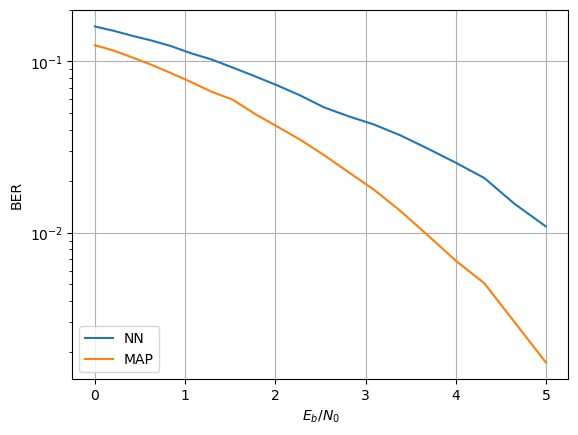

In [11]:
legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits)
legend.append('NN') 

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP') 

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()